<a href="https://colab.research.google.com/github/DrigoDomingos/onfarm/blob/master/onfarm_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload the files

In [1]:
!unzip dp_model.zip

Archive:  dp_model.zip
   creating: dp_model/
  inflating: dp_model/.gitignore     
   creating: dp_model/azul_claro/
  inflating: dp_model/azul_claro/0.jpg  
  inflating: dp_model/azul_claro/0.xml  
  inflating: dp_model/azul_claro/1.jpg  
  inflating: dp_model/azul_claro/1.xml  
  inflating: dp_model/azul_claro/10.jpg  
  inflating: dp_model/azul_claro/10.xml  
  inflating: dp_model/azul_claro/100.jpg  
  inflating: dp_model/azul_claro/101.jpg  
  inflating: dp_model/azul_claro/102.jpg  
  inflating: dp_model/azul_claro/103.jpg  
  inflating: dp_model/azul_claro/104.jpg  
  inflating: dp_model/azul_claro/105.jpg  
  inflating: dp_model/azul_claro/106.jpg  
  inflating: dp_model/azul_claro/107.jpg  
  inflating: dp_model/azul_claro/108.jpg  
  inflating: dp_model/azul_claro/109.jpg  
  inflating: dp_model/azul_claro/11.jpg  
  inflating: dp_model/azul_claro/11.xml  
  inflating: dp_model/azul_claro/110.jpg  
  inflating: dp_model/azul_claro/111.jpg  
  inflating: dp_model/azul_claro/1

In [0]:
cd dp_model/

/content/dp_model


# Convert XML to CSV

In [0]:
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile


def convert_xml2csv(path):
  annotations = glob(path)
  df = []
  cnt = 0
  for file in annotations:
      #filename = file.split('/')[-1].split('.')[0] + '.jpg'
      #filename = str(cnt) + '.jpg'
      filename = file.split('\\')[-1]
      filename =filename.split('.')[0] + '.jpg'
      row = []
      parsedXML = ET.parse(file)
      for node in parsedXML.getroot().iter('object'):
          blood_cells = node.find('name').text
          xmin = int(node.find('bndbox/xmin').text)
          xmax = int(node.find('bndbox/xmax').text)
          ymin = int(node.find('bndbox/ymin').text)
          ymax = int(node.find('bndbox/ymax').text)

          row = [filename, blood_cells, xmin, xmax, ymin, ymax]
          df.append(row)
          cnt += 1

  data = pd.DataFrame(df, columns=['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

  data[['filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('test.csv', index=False)


#Azul claro
convert_xml2csv('/content/dp_model/azul_claro/*.xml')


# Install libraries

In [3]:
!head test.csv

filename,cell_type,xmin,xmax,ymin,ymax
/content/dp_model/azul_claro/2.jpg,azul_claro,1235,1283,263,306
/content/dp_model/azul_claro/2.jpg,azul_claro,1232,1278,357,403
/content/dp_model/azul_claro/2.jpg,azul_claro,1302,1343,284,330
/content/dp_model/azul_claro/2.jpg,azul_claro,1359,1405,365,414
/content/dp_model/azul_claro/2.jpg,azul_claro,1589,1624,336,371
/content/dp_model/azul_claro/2.jpg,azul_claro,1248,1294,438,495
/content/dp_model/azul_claro/2.jpg,azul_claro,1316,1359,436,490
/content/dp_model/azul_claro/2.jpg,azul_claro,1272,1332,509,568
/content/dp_model/azul_claro/2.jpg,azul_claro,1575,1632,379,441


In [0]:
# importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches

In [9]:
# read the csv file using read_csv function of pandas
train = pd.read_csv('test.csv')
train.head()

,filename,cell_type,xmin,xmax,ymin,ymax
0,/content/dp_model/azul_claro/2.jpg,azul_claro,1235,1283,263,306
1,/content/dp_model/azul_claro/2.jpg,azul_claro,1232,1278,357,403
2,/content/dp_model/azul_claro/2.jpg,azul_claro,1302,1343,284,330
3,/content/dp_model/azul_claro/2.jpg,azul_claro,1359,1405,365,414
4,/content/dp_model/azul_claro/2.jpg,azul_claro,1589,1624,336,371


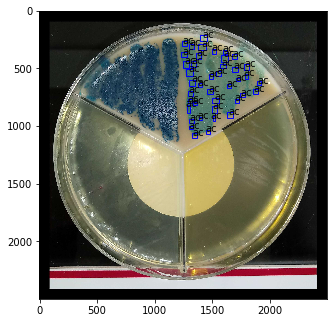

In [11]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/dp_model/azul_claro/2.jpg')
plt.imshow(image)

# iterating over the image for different objects
for _,row in train[train.filename == "/content/dp_model/azul_claro/2.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cell_type == 'azul_claro':
        edgecolor = 'b'
        ax.annotate('ac', xy=(xmax-40,ymin+20))
 #   elif row.cell_type == 'WBC':
 #       edgecolor = 'b'
 #       ax.annotate('WBC', xy=(xmax-40,ymin+20))
 #   elif row.cell_type == 'Platelets':
 #       edgecolor = 'g'
 #       ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)

In [0]:
data = pd.DataFrame()
data['format'] = train['filename']

# as the images are in train_images folder, add train_images before the image name
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train['xmin'][i]) + ',' + str(train['ymin'][i]) + ',' + str(train['xmax'][i]) + ',' + str(train['ymax'][i]) + ',' + train['cell_type'][i]

data.to_csv('annotate.txt', header=None, index=None, sep=' ')

In [17]:
!head annotate.txt

/content/dp_model/azul_claro/2.jpg,1235,263,1283,306,azul_claro
/content/dp_model/azul_claro/2.jpg,1232,357,1278,403,azul_claro
/content/dp_model/azul_claro/2.jpg,1302,284,1343,330,azul_claro
/content/dp_model/azul_claro/2.jpg,1359,365,1405,414,azul_claro
/content/dp_model/azul_claro/2.jpg,1589,336,1624,371,azul_claro
/content/dp_model/azul_claro/2.jpg,1248,438,1294,495,azul_claro
/content/dp_model/azul_claro/2.jpg,1316,436,1359,490,azul_claro
/content/dp_model/azul_claro/2.jpg,1272,509,1332,568,azul_claro
/content/dp_model/azul_claro/2.jpg,1575,379,1632,441,azul_claro
/content/dp_model/azul_claro/2.jpg,1667,376,1718,419,azul_claro


In [21]:
!pip install -r dp_model/requirements.txt

     |████████████████████████████████| 204kB 2.8MB/s 
  Created wheel for Keras: filename=Keras-2.0.3-cp36-none-any.whl size=232962 sha256=f932ab23d01bf6dd52da466182f059a94457111512a5b1690d92a3b4e67154a7
  Stored in directory: /root/.cache/pip/wheels/a6/fb/de/faea9e49d563a35f198c6dede7f9260074b5beb8f9bffaaaa1
Successfully built Keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.3 which is incompatible.
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
!python3 dp_model/train_frcnn.py -o simple -p annotate.txt

Using TensorFlow backend.
Parsing annotation files
Training images per class:
{'azul_claro': 770, 'bg': 0}
Num classes (including bg) = 2
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 14
Num val samples 2







Instructions for updating:
keep_dims is deprecated, use keepdims instead
loading weights from resnet50_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder 		https://github.com/fchollet/keras/tree/master/keras/applications


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Starting training
Epoch 1/2000

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




2020-02-08 13:21:42.921760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Fr